In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.initializers import RandomNormal
from keras.layers import Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, Input, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from tqdm import tqdm_notebook
import glob
import cv2
%matplotlib inline


# GAN network class 


class GAN():
  def __init__(self, input_data):
    self.img_rows = 64
    self.img_cols = 64
    self.channels = 3
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 100
    optimizer = Adam(0.0002, 0.5)
    self.x_train = np.asarray(input_data)
    self.discriminator = self.create_discriminator()
    self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    self.generator = self.create_generator()
    z = Input(shape=(self.latent_dim,))
    img = self.generator(z)
    self.discriminator.trainable = False
    validity = self.discriminator(img)
    self.combined = Model(z, validity)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)



# Define Generator network


  def create_generator(self):
    generator = Sequential()   
    # Starting size
    d = 4
    generator.add(Dense(d*d*1024, kernel_initializer=RandomNormal(0, 0.02), input_dim = self.latent_dim))
    generator.add(LeakyReLU(0.2))
    # 4x4x1024
    generator.add(Reshape((d, d, 1024))) 
    # 8x8x512
    generator.add(Conv2DTranspose(512, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2)) 
    # 16x16*256
    generator.add(Conv2DTranspose(256, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2)) 
    # 32x32x128
    generator.add(Conv2DTranspose(128, (4, 4), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    generator.add(LeakyReLU(0.2))
    # 64x64x3
    generator.add(Conv2DTranspose(self.channels, (4, 4), strides=2, padding='same', activation='tanh', kernel_initializer=RandomNormal(0, 0.02)))
    # generator.summary()
    noise = Input(shape=(self.latent_dim,))
    img = generator(noise)
    return Model(noise, img)


# Define discriminator network


  def create_discriminator(self):
    discriminator = Sequential()
    discriminator.add(Conv2D(64, (3, 3), padding='same', kernel_initializer=RandomNormal(0, 0.02), input_shape=self.img_shape))
    discriminator.add(LeakyReLU(0.2)) 
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Conv2D(128, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))  
    discriminator.add(Conv2D(256, (3, 3), strides=2, padding='same', kernel_initializer=RandomNormal(0, 0.02)))
    discriminator.add(LeakyReLU(0.2))  
    discriminator.add(Flatten())
    discriminator.add(Dropout(0.4))
    discriminator.add(Dense(1, activation='sigmoid', input_shape=self.img_shape))  
    # discriminator.summary()
    img = Input(shape=self.img_shape)
    validity = discriminator(img)
    return Model(img, validity)



# Train GAN network


  def train(self, epochs = 2, batch_size=256):
    # Normalize data 
    x_train = (self.x_train.astype(np.float32) - 127.5) / 127.5
    # Constant noise for viewing how the GAN progresses
    static_noise = np.random.normal(0, 1, size=(100, self.latent_dim))
    steps_per_epoch = int(x_train.shape[0] / batch_size)
    # Training loop
    for epoch in range(epochs + 1):
      for batch in tqdm_notebook(range(steps_per_epoch), desc = 'epoch {}'.format(epoch)):
        noise = np.random.normal(0, 1, size=(batch_size, self.latent_dim))
        real_x = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]
        fake_x = self.generator.predict(noise)
        x = np.concatenate((real_x, fake_x))
        disc_y = np.zeros(2*batch_size)
        disc_y[:batch_size] = 0.9
        d_loss = self.discriminator.train_on_batch(x, disc_y)
        y_gen = np.ones(batch_size)
        g_loss = self.combined.train_on_batch(noise, y_gen)
      print(f'\t Discriminator Loss: {d_loss} \t\t Generator Loss: {g_loss}')
      if epoch % 10 == 0:
        self.show_images(static_noise, epoch)



  # Display images, and save them if the epoch number is specified


  def show_images(self, noise, epoch=None):
    save_path = 'gan-images'
    # Create path for saving images
    if save_path != None and not os.path.isdir(save_path):
      os.mkdir(save_path)
    generated_images = self.generator.predict(noise)
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(generated_images[:25]):
        plt.subplot(5, 5, i+1)
        norm_sample = (image*127.5+127.5).astype(np.uint8)
        norm_sample = cv2.cvtColor(norm_sample, cv2.COLOR_BGR2RGB)
        plt.imshow(norm_sample)
        plt.axis('off')  
    plt.tight_layout()  
    if epoch != None and save_path != None:
        plt.savefig(f'{save_path}/gan-images_epoch-{epoch}.png')
    plt.show()



def read_data(file_path = "/content/drive/My Drive/jobe/mini_face_dataset/*.jpg"):
  templates_files = glob.glob(file_path)
  print(len(templates_files))
  templates = []
  for tn in tqdm_notebook(range(len(templates_files)), desc = 'load images'):
    t = templates_files[tn]
    img = cv2.imread(t)
    templates.append(img)
  return templates

In [ ]:
np.random.seed(1337)
input_gan = read_data()

In [ ]:
gan = GAN(input_gan)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 256)        

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'



	 Discriminator Loss: 0.8953874111175537 		 Generator Loss: 1.373703956604004


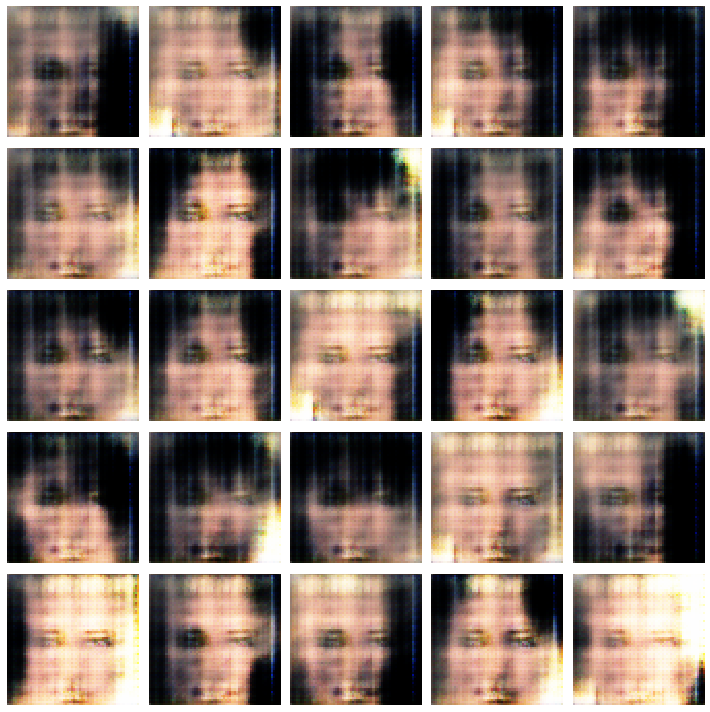


	 Discriminator Loss: 0.4837437868118286 		 Generator Loss: 1.3801921606063843



	 Discriminator Loss: 0.5602907538414001 		 Generator Loss: 1.340517282485962



	 Discriminator Loss: 0.657611072063446 		 Generator Loss: 0.991737425327301



	 Discriminator Loss: 0.6566100120544434 		 Generator Loss: 0.9545047283172607



	 Discriminator Loss: 0.6534808278083801 		 Generator Loss: 1.0990796089172363



	 Discriminator Loss: 0.6601194739341736 		 Generator Loss: 1.1210918426513672



	 Discriminator Loss: 0.6358222961425781 		 Generator Loss: 0.9637423753738403



	 Discriminator Loss: 0.6042928099632263 		 Generator Loss: 0.9720509648323059



	 Discriminator Loss: 0.729160487651825 		 Generator Loss: 1.1437370777130127



	 Discriminator Loss: 0.6711568236351013 		 Generator Loss: 0.896821141242981


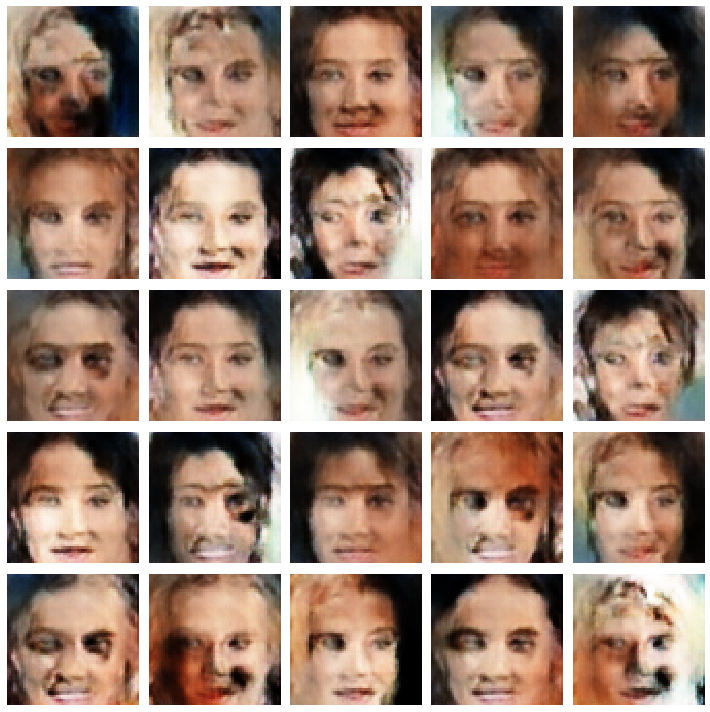


	 Discriminator Loss: 0.6349388360977173 		 Generator Loss: 1.06027352809906



	 Discriminator Loss: 0.6155974864959717 		 Generator Loss: 1.0127531290054321



	 Discriminator Loss: 0.6754155158996582 		 Generator Loss: 0.8412968516349792



	 Discriminator Loss: 0.6428745985031128 		 Generator Loss: 1.0079410076141357



	 Discriminator Loss: 0.6889211535453796 		 Generator Loss: 0.9416887760162354



	 Discriminator Loss: 0.6592608690261841 		 Generator Loss: 1.38639497756958



	 Discriminator Loss: 0.6852917075157166 		 Generator Loss: 0.8629330396652222



	 Discriminator Loss: 0.6332640051841736 		 Generator Loss: 1.1143898963928223



	 Discriminator Loss: 0.6887309551239014 		 Generator Loss: 0.977920651435852



	 Discriminator Loss: 0.6478409171104431 		 Generator Loss: 1.0799551010131836


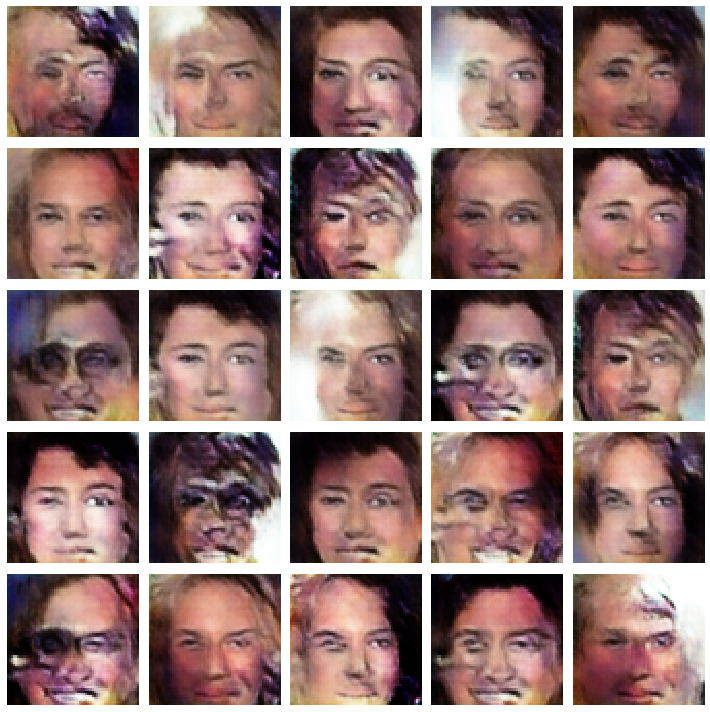


	 Discriminator Loss: 0.6244082450866699 		 Generator Loss: 0.9133133888244629



	 Discriminator Loss: 0.6392107009887695 		 Generator Loss: 1.0552823543548584



	 Discriminator Loss: 0.6498706340789795 		 Generator Loss: 0.9556331634521484



	 Discriminator Loss: 0.6325328350067139 		 Generator Loss: 0.9556703567504883



	 Discriminator Loss: 0.7012537717819214 		 Generator Loss: 1.8187998533248901



	 Discriminator Loss: 0.7110630869865417 		 Generator Loss: 0.9042826890945435



	 Discriminator Loss: 0.6309130787849426 		 Generator Loss: 0.960511326789856



	 Discriminator Loss: 0.6496540307998657 		 Generator Loss: 0.9631085395812988



	 Discriminator Loss: 0.6763872504234314 		 Generator Loss: 0.9642298221588135



	 Discriminator Loss: 0.6434984803199768 		 Generator Loss: 1.0502570867538452


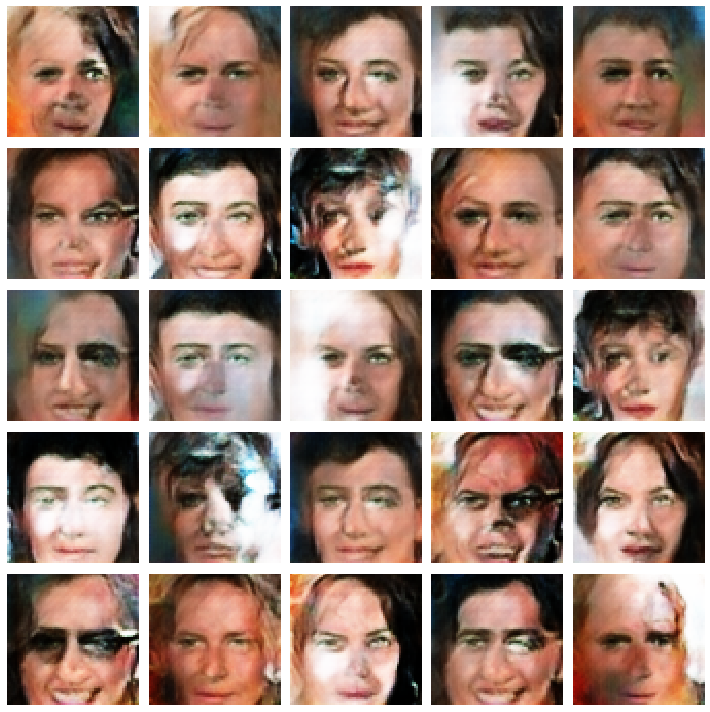


	 Discriminator Loss: 0.6699730753898621 		 Generator Loss: 0.9971636533737183



	 Discriminator Loss: 0.6337610483169556 		 Generator Loss: 0.9972776174545288



	 Discriminator Loss: 0.6396452188491821 		 Generator Loss: 1.2945945262908936



	 Discriminator Loss: 0.6477043628692627 		 Generator Loss: 0.8893383145332336



	 Discriminator Loss: 0.6361886858940125 		 Generator Loss: 0.9497168064117432



	 Discriminator Loss: 0.6354965567588806 		 Generator Loss: 0.9743597507476807



	 Discriminator Loss: 0.6323931217193604 		 Generator Loss: 0.9944215416908264



	 Discriminator Loss: 0.7453649640083313 		 Generator Loss: 1.1295961141586304



	 Discriminator Loss: 0.6652783155441284 		 Generator Loss: 0.9499998092651367



	 Discriminator Loss: 0.624821662902832 		 Generator Loss: 0.9825333952903748


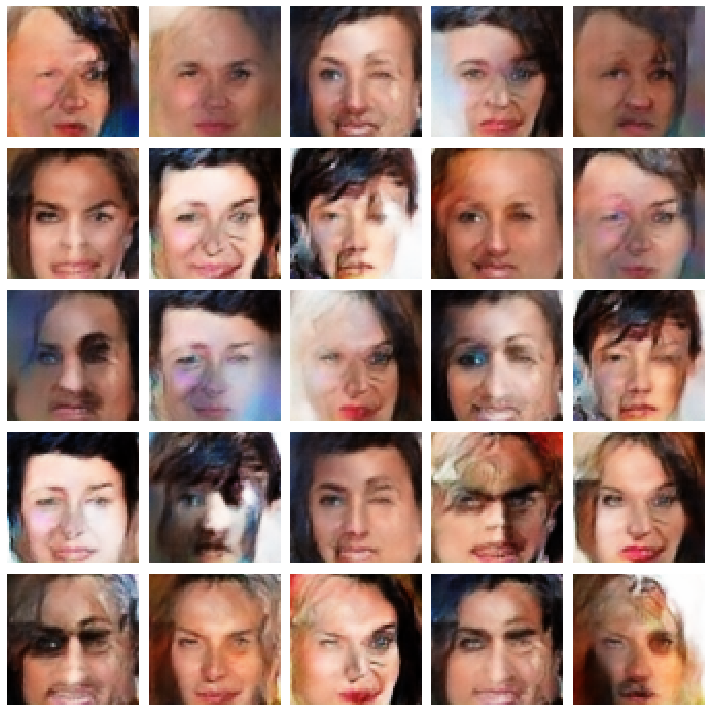


	 Discriminator Loss: 0.643159806728363 		 Generator Loss: 0.8862392902374268



	 Discriminator Loss: 0.6410688757896423 		 Generator Loss: 0.9503647685050964



	 Discriminator Loss: 0.5678120851516724 		 Generator Loss: 1.0839468240737915



	 Discriminator Loss: 0.6460182070732117 		 Generator Loss: 0.9189174175262451



	 Discriminator Loss: 0.6563320159912109 		 Generator Loss: 1.0321146249771118



	 Discriminator Loss: 0.6749774217605591 		 Generator Loss: 0.8235054016113281



	 Discriminator Loss: 0.6677172780036926 		 Generator Loss: 1.1119804382324219



	 Discriminator Loss: 1.3051981925964355 		 Generator Loss: 0.8276020884513855



	 Discriminator Loss: 0.6379725933074951 		 Generator Loss: 0.895720899105072


In [ ]:
gan.train(epochs=50, batch_size=256)